# 💊 MedGuard Debate
AI-driven multi-agent debate system for clinical drug interaction analysis.

🔗 Related: See [DrugX](https://drugx.lisekarimi.com) - a production-ready drug interaction platform that queries real medical databases (RxNorm, OpenFDA, DrugBank) to deliver FDA-validated safety assessments without LLM hallucination risks.

- 🌍 Task: Evaluate medication safety through adversarial multi-perspective debate among specialized medical AI agents
- 🧠 Model: OpenAI (gpt-4o-mini agents + o3-mini judge)
- 🎯 Process: 👤User → 🎭3 Agentic Debaters (Cautious/Pragmatic/Patient-Advocate) investigate & argue in parallel → ⚖️ Judge LLM synthesizes verdict → 📋 Clinical Decision
- 📌 Output Format: Structured debate with evidence-based arguments from each perspective + judge's balanced clinical recommendation
- 🔧 Tools: Mock medical knowledge bases + OpenAI API + asyncio parallel execution
- 🧑‍💻 Skill Level: Intermediate - needs async Python, agentic design, and multi-agent orchestration

🛠️ Requirements
- ⚙️ Hardware: ✅ CPU is sufficient — no GPU required
- 🔑 OpenAI API Key
- IPython environment (Jupyter/Colab)

---
📢 Discover more Agentic AI notebooks on my [GitHub repository](https://github.com/lisekarimi/agentverse) and explore additional AI projects on my [portfolio](https://lisekarimi.com).

NB : 

- **This demo code simulates medical evidence with mock data for demonstration purposes - it doesn't make actual API calls to real medical databases.**

- We use **async** for parallel processing in the **coordinator**:
   - **Without async:** Agent 1 → finish → Agent 2 → finish → Agent 3 (slow, sequential)
   - **With async:** All 3 agents investigate simultaneously in the **coordinator** (~1-2 seconds total)

The `AgenticDebateCoordinator` manages the parallel execution using `asyncio.gather(*tasks)`.

##  MedGuard Debate Workflow: Parallel Agentic Debate

Multi-agent debate pattern - each agent autonomously investigates from their perspective, then a judge evaluates all arguments.

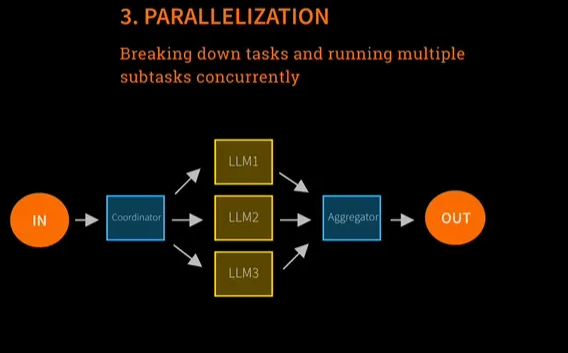

- 3 agentic LLMs (Cautious/Pragmatic/Patient-Advocate) investigate and build arguments simultaneously
- Each agent gathers evidence → constructs argument → judge evaluates debate
- Same medications to all agents, parallel investigation, judge renders verdict

![](https://github.com/lisekarimi/agentverse/blob/main/assets/02_medguard-workflow.png?raw=true)


In [ ]:
# Import dependencies
import asyncio
import random
from typing import List, Dict
from openai import OpenAI

In [ ]:
# Model configuration
MODEL_AGENT = "gpt-4o-mini"
MODEL_JUDGE = "o3-mini"

In [ ]:
class MedicalKnowledgeBase:
    """Mock medical research database with biased perspectives"""

    @staticmethod
    def get_cautious_evidence(medications: List[str]) -> Dict:
        """Returns worst-case scenarios and severe warnings"""
        evidence = {
            "case_reports": [
                f"Case Study #2847: Patient on {medications[0]} experienced severe adverse reaction when {medications[1]} was added",
                f"Meta-analysis shows {random.randint(15, 40)}% increased risk of complications"
            ],
            "warnings": [
                "FDA Black Box Warning: Concomitant use may lead to serious outcomes",
                "Contraindication found in elderly patients (>65 years)"
            ],
            "statistics": {
                "adverse_events": random.randint(1200, 5000),
                "severity_score": random.uniform(7.5, 9.5)
            }
        }
        return evidence

    @staticmethod
    def get_pragmatic_evidence(medications: List[str]) -> Dict:
        """Returns balanced clinical practice data"""
        evidence = {
            "clinical_guidelines": [
                f"ACC/AHA Guidelines: {medications[0]} + {medications[1]} acceptable with monitoring",
                f"Real-world study: {random.randint(60, 85)}% of patients tolerate combination well"
            ],
            "management_strategies": [
                "Dose adjustment protocol available for safe co-administration",
                f"Monitor labs every {random.randint(1, 4)} weeks during concurrent use"
            ],
            "statistics": {
                "successful_cases": random.randint(10000, 50000),
                "prescribing_frequency": f"{random.randint(20, 45)}% of specialists use this combination"
            }
        }
        return evidence

    @staticmethod
    def get_risk_benefit_evidence(medications: List[str], condition: str = "chronic pain") -> Dict:
        """Returns patient-centered outcomes data"""
        evidence = {
            "patient_outcomes": [
                f"Quality of life improved in {random.randint(65, 85)}% of patients despite interaction risk",
                f"Alternative therapies showed {random.randint(30, 50)}% lower efficacy"
            ],
            "alternatives": [
                "Alternative drug X: Less effective but safer profile",
                f"Non-pharmacological options: Limited success in {condition}"
            ],
            "necessity_factors": [
                f"Patient condition: {condition} - requires effective management",
                f"Previous treatment failures: {random.randint(2, 5)} alternatives tried"
            ]
        }
        return evidence


In [ ]:
class DebateAgent:
    """Agentic LLM that argues from a specific medical perspective"""

    def __init__(self, agent_id: str, perspective: str, stance: str):
        self.agent_id = agent_id
        self.perspective = perspective  # "cautious", "pragmatic", "risk-benefit"
        self.stance = stance
        self.client = OpenAI()

    async def build_argument(self, medications: List[str], patient_context: str = "") -> Dict:
        """Agent autonomously gathers evidence and builds argument"""

        print(f"🤖 {self.agent_id} is investigating...")

        # Agent autonomously selects evidence based on perspective
        if self.perspective == "cautious":
            evidence = MedicalKnowledgeBase.get_cautious_evidence(medications)
        elif self.perspective == "pragmatic":
            evidence = MedicalKnowledgeBase.get_pragmatic_evidence(medications)
        else:  # risk-benefit
            evidence = MedicalKnowledgeBase.get_risk_benefit_evidence(medications)

        # Agent constructs argument using LLM
        prompt = self._create_debate_prompt(medications, evidence, patient_context)

        try:
            argument = await self._call_openai(prompt)
        except Exception as e:
            raise RuntimeError(f"❌ LLM API Failed for {self.agent_id}: {str(e)}")

        return {
            "agent": self.agent_id,
            "perspective": self.perspective,
            "stance": self.stance,
            "evidence_gathered": evidence,
            "argument": argument
        }

    def _create_debate_prompt(self, medications: List[str], evidence: Dict, patient_context: str) -> str:
        prompt = f"""
You are {self.agent_id}, a medical AI agent with a {self.perspective} perspective on drug safety.

MEDICATIONS TO ANALYZE: {' + '.join(medications)}
PATIENT CONTEXT: {patient_context if patient_context else "Standard adult patient"}

YOUR STANCE: {self.stance}

EVIDENCE YOU'VE GATHERED:
{self._format_evidence(evidence)}

YOUR TASK:
Build a compelling argument for your stance. You are in a debate with other medical agents.

1. Present your key concern or recommendation
2. Cite the specific evidence you found (reference the studies/data above)
3. Address potential counterarguments
4. Conclude with a clear clinical recommendation

Be persuasive but medically accurate. Use your evidence strategically.
Stay in character as a {self.perspective} medical advisor.

Format your response as a structured argument with clear reasoning.
"""
        return prompt

    def _format_evidence(self, evidence: Dict) -> str:
        """Format evidence dict into readable text"""
        formatted = ""
        for key, value in evidence.items():
            formatted += f"\n{key.upper().replace('_', ' ')}:\n"
            if isinstance(value, list):
                for item in value:
                    formatted += f"  - {item}\n"
            elif isinstance(value, dict):
                for k, v in value.items():
                    formatted += f"  - {k}: {v}\n"
            else:
                formatted += f"  - {value}\n"
        return formatted

    async def _call_openai(self, prompt: str) -> str:
        response = await asyncio.get_event_loop().run_in_executor(
            None,
            lambda: self.client.chat.completions.create(
                model=MODEL_AGENT,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=400,
                temperature=0.7
            )
        )
        return response.choices[0].message.content.strip()

In [ ]:
class JudgeAgent:
    """Evaluates debate and synthesizes final medical recommendation"""

    def __init__(self):
        self.client = OpenAI()

    async def judge_debate(self, arguments: List[Dict], medications: List[str]) -> Dict:
        """Analyzes all arguments and renders verdict"""

        print("⚖️  Judge is deliberating...")

        prompt = self._create_judge_prompt(arguments, medications)

        try:
            verdict = self._call_openai_judge(prompt)
        except Exception as e:
            raise RuntimeError(f"❌ Judge LLM API Failed: {str(e)}")

        return {
            "medications": medications,
            "arguments_reviewed": len(arguments),
            "final_verdict": verdict
        }

    def _create_judge_prompt(self, arguments: List[Dict], medications: List[str]) -> str:
        debate_summary = ""
        for arg in arguments:
            debate_summary += f"\n{'='*60}\n"
            debate_summary += f"{arg['agent']} ({arg['perspective'].upper()} PERSPECTIVE):\n"
            debate_summary += f"Stance: {arg['stance']}\n\n"
            debate_summary += f"{arg['argument']}\n"

        prompt = f"""
You are a senior clinical judge synthesizing a debate about drug interactions.

MEDICATIONS: {' + '.join(medications)}

DEBATE ARGUMENTS:
{debate_summary}

YOUR TASK AS JUDGE:
1. Evaluate the strength of each argument
2. Identify which concerns are most clinically significant
3. Note where agents agree and disagree
4. Synthesize a balanced, evidence-based final recommendation

Your verdict should:
- Acknowledge valid points from each perspective
- Provide clear clinical guidance
- Include specific monitoring/management recommendations
- State final risk level: SAFE / CAUTION / WARNING / CONTRAINDICATED

Be thorough and fair. This is a clinical decision that affects patient care.
"""
        return prompt

    def _call_openai_judge(self, prompt: str) -> str:
        response = self.client.chat.completions.create(
            model=MODEL_JUDGE,
            messages=[{"role": "user", "content": prompt}]
        )
        return response.choices[0].message.content.strip()


In [ ]:
class AgenticDebateCoordinator:
    """Orchestrates the multi-agent debate system"""

    def __init__(self):
        self.agents = [
            DebateAgent(
                "Dr_Safety_First",
                "cautious",
                "These medications should NOT be combined - risks outweigh benefits"
            ),
            DebateAgent(
                "Dr_Evidence_Based",
                "pragmatic",
                "Combination is acceptable with proper monitoring and management"
            ),
            DebateAgent(
                "Dr_Patient_Advocate",
                "risk-benefit",
                "Patient needs effective treatment - we must balance safety with quality of life"
            )
        ]
        self.judge = JudgeAgent()

    async def conduct_debate(self, medications: List[str], patient_context: str = "") -> Dict:
        print(f"{'='*70}")
        print("🏥 AGENTIC DRUG INTERACTION DEBATE")
        print(f"{'='*70}")
        print(f"📋 Medications: {' + '.join(medications)}")
        print(f"👤 Patient Context: {patient_context if patient_context else 'Standard adult patient'}")
        print(f"\n🎭 {len(self.agents)} agents are building their arguments...\n")

        # Each agent autonomously investigates and builds argument
        tasks = [agent.build_argument(medications, patient_context) for agent in self.agents]
        arguments = await asyncio.gather(*tasks)

        print("\n✅ All arguments prepared. Proceeding to judge...\n")

        # Judge evaluates the debate
        verdict = await self.judge.judge_debate(arguments, medications)

        return {
            "medications": medications,
            "patient_context": patient_context,
            "arguments": arguments,
            "verdict": verdict
        }

    def display_debate(self, results: Dict):
        """Format and display the debate results"""
        print(f"\n{'='*70}")
        print("📊 DEBATE RESULTS")
        print(f"{'='*70}\n")

        # Display each agent's argument
        for i, arg in enumerate(results['arguments'], 1):
            print(f"{'─'*70}")
            print(f"🎤 ARGUMENT #{i}: {arg['agent']}")
            print(f"{'─'*70}")
            print(f"📌 Perspective: {arg['perspective'].upper()}")
            print(f"🎯 Stance: {arg['stance']}")
            print("\n💬 ARGUMENT:")
            print(f"{arg['argument']}")
            print()

        # Display judge's verdict
        print(f"\n{'='*70}")
        print("⚖️  JUDGE'S FINAL VERDICT")
        print(f"{'='*70}")
        print(f"{results['verdict']['final_verdict']}")
        print(f"{'='*70}\n")


In [ ]:
async def main():
    coordinator = AgenticDebateCoordinator()

    # Test case 1: Classic dangerous interaction
    print("🚀 Starting Agentic Debate System...\n")

    test_cases = [
        {
            "medications": ["Warfarin", "Ibuprofen"],
            "context": "72-year-old patient with atrial fibrillation and severe osteoarthritis"
        },
        # Uncomment to test more scenarios:
        # {
        #     "medications": ["Metformin", "Alcohol"],
        #     "context": "45-year-old diabetic patient, social drinker"
        # },
        # {
        #     "medications": ["SSRI Antidepressant", "Tramadol"],
        #     "context": "Patient with depression and chronic back pain"
        # }
    ]

    for test in test_cases:
        results = await coordinator.conduct_debate(
            test["medications"],
            test["context"]
        )
        coordinator.display_debate(results)
        await asyncio.sleep(1)

In [ ]:
# Run the debate system
await main()